# ATML2021 Assignment 2 [Name LastName]

In [97]:
import os
!nvidia-smi
if not os.path.isfile('nms.py'):
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/nms.py" "nms.py"
    !unzip -qq "/content/drive/My Drive/ATML/Assignments/Assignment2/Assignment2_data.zip"

Sun Apr 25 19:15:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W /  70W |   2942MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm import tqdm
from nms import nms
import os
import cv2 # pip install opencv-python

# 1. Train a convolutional neural network for binary classification
Your network will learn to classify 48x48 patches into two classes: noface/face. Instructions in the pdf.

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [100]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

transforms = Compose([ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_dataset = ImageFolder('train', transform=transforms)
val_dataset = ImageFolder('val', transform=transforms)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

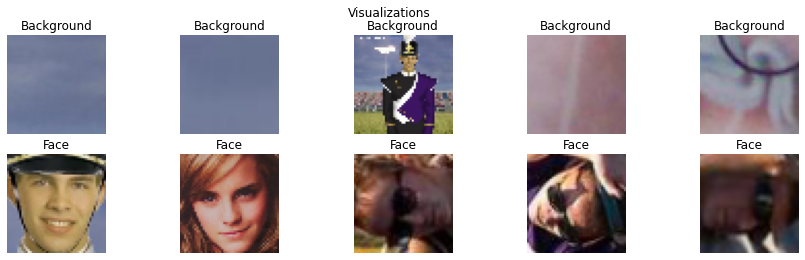

In [101]:
plt.subplots(2,5,figsize=(15,4))
plt.suptitle('Visualizations')
img_bg = 0
img_face = 0

_t_mean=[0.5, 0.5, 0.5]
_t_std=[0.5, 0.5, 0.5]

def _imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(_t_mean)
    std = np.array(_t_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)

for _img in train_dataset:
    if img_bg == 5 and img_face == 5:
        break
    else:
        if _img[1] == 0 and img_bg < 5:
            img_bg += 1
            plt.subplot(2,5,img_bg)
            _imshow(_img[0], "Background")
        if _img[1] == 1 and img_face < 5:
            img_face += 1
            plt.subplot(2,5, img_face + 5)
            _imshow(_img[0], "Face")
        plt.axis('off')

In [102]:
def train(model, train_loader, optimizer, loss_fn, print_every=100):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
#         if iteration % print_every == 0:
#             print('Training iteration {}: loss {:.4f}'.format(iteration, loss.item()))
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
#     print('Test average loss: {:.4f}, accuracy: {:.3f}'.format(average_loss, accuracy))
    return average_loss, accuracy


def fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if scheduler:
            scheduler.step() # argument only needed for ReduceLROnPlateau
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [103]:
class ConvModel(nn.Module):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        self.layer1 = nn.Sequential(
            # Convolutional layer, filter size 3x3, stride 1, 32 channels
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            # Max Pooling layer, input 3x3, stride 2, ceil mode=True
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # Activation function LeakyReLU, slope 0.2
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer2 = nn.Sequential(
            # Convolutional layer, filter size 3x3, stride 1, 64 channels
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            # Max Pooling layer, input 3x3, stride 2
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Activation function LeakyReLU, slope 0.2
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer3 = nn.Sequential(
            # Convolutional layer, filter size 3x3, stride 1, 64 channels
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            # Max Pooling layer, input 2x2, stride 2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Activation function LeakyReLU, slope 0.2
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer4 = nn.Sequential(
            # Convolutional layer, filter size 2x2, stride 1, 128 channels
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            # Activation function LeakyReLU, slope 0.2
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.layer5 = nn.Sequential(
            # Convolutional layer, filter size 3x3, stride 1, 256 channels
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            # Activation function LeakyReLU, slope 0.2
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer6 = nn.Sequential(
            # Convolutional layer, filter size 1x1, stride 1, 2 (output) channels 
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1)
        )
    
    def forward(self, input):        
        output = self.layer1(input)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)
        output = self.layer6(output)
        output = output.view(output.size(0), -1)
        return output

In [104]:
model_conv = ConvModel()
model_conv = model_conv.to(device)
learning_rate = 3e-4
optimizer = torch.optim.Adam(model_conv2.parameters(), lr=learning_rate)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [93]:
curves_conv2 = fit(train_dataloader, val_dataloader, model_conv2, optimizer, loss_fn, n_epochs)

Epoch 1/10: train_loss: 0.2370, train_accuracy: 90.3806, val_loss: 0.1830, val_accuracy: 92.9700
Epoch 2/10: train_loss: 0.1594, train_accuracy: 93.9288, val_loss: 0.1489, val_accuracy: 94.2600
Epoch 3/10: train_loss: 0.1369, train_accuracy: 94.8746, val_loss: 0.1351, val_accuracy: 94.9800
Epoch 4/10: train_loss: 0.1242, train_accuracy: 95.3190, val_loss: 0.1337, val_accuracy: 94.8800
Epoch 5/10: train_loss: 0.1150, train_accuracy: 95.6996, val_loss: 0.1215, val_accuracy: 95.4100
Epoch 6/10: train_loss: 0.1051, train_accuracy: 96.1104, val_loss: 0.1195, val_accuracy: 95.5800
Epoch 7/10: train_loss: 0.0974, train_accuracy: 96.3700, val_loss: 0.1146, val_accuracy: 95.7300
Epoch 8/10: train_loss: 0.0883, train_accuracy: 96.6835, val_loss: 0.1174, val_accuracy: 95.9100
Epoch 9/10: train_loss: 0.0819, train_accuracy: 96.9308, val_loss: 0.1216, val_accuracy: 95.6900
Epoch 10/10: train_loss: 0.0743, train_accuracy: 97.2095, val_loss: 0.1216, val_accuracy: 95.5000


# 2. Implement fully convolutional face detector that uses the binary classifier
Use your trained binary classification model for face detection in bigger images.  
Follow the instructions in the pdf and in the comments 

In [94]:
class FullyConvolutionalDetector:
    def __init__(self, model, max_res=1024, scales=[1.0, 0.8, 0.6, 0.4, 0.2, 0.1], threshold=0.5):
        self.model = model
        self.max_res = max_res
        self.scales = scales
        self.threshold = threshold
    
    @torch.no_grad()
    def detect_single_scale(self, image):
        '''Run a fully convolutional model on the input image'''
        '''Image is assumed to be of shape HxWx3 and scaled to [0,1]'''
        ## TODO
        ## Preprocess the image (subtract and divide as in training)
        pass
        ## Convert the image to a tensor of shape 1x3xHxW; move it to the same device as the model
        pass
        ## Run the self.model on the image
        pass
        ## Process the output with softmax (torch.softmax) on the channel dimension
        pass
        ## Get probabilities for the face class (discard the non-face class)
        pass
        ## Find output coordinates where the face probability > self.threshold
        ## (hint: you can convert output to numpy and use np.where)
        pass
        ## Convert selected output coordinates to input coordinates 
        ## You should return coordinates as a numpy array of shape Nx4 (N - detected faces)
        ## each row are coordinates x1, y1, x2, y2 - top left and bottom right corner of a rectangle
        pass
        ## Return face coordinates and their probabilities
        return face_coordiantes, face_probabilities
    
    @torch.no_grad()
    def detect_multi_scale(self, image, nms=True):
        '''Run the detector on a pyramid of images (same image in different scales)'''
        all_face_coordinates = []
        all_face_probabilities = []
        for scale in self.scales:
            H, W, C = image.shape
            scale_factor = float(self.max_res) / max(H, W) * scale
            ## TODO resize the image by scale_factor (e.g. cv2.resize, convert to PIL.Image and resize...)
            pass
            ## Run detect_single_scale on resized image
            pass
            ## Scale back the returned face coordinates to original image coordinates
            pass
            ## Append detected face coordinates and probabilities to all_face_coordinates and probabilities
            pass
        all_face_coordinates = np.concatenate(all_face_coordinates, 0)
        all_face_probabilities = np.concatenate(all_face_probabilities)
        if nms==True and len(all_face_coordinates) > 0: # merge overlapping predictions
            results = np.concatenate((all_face_coordinates, all_face_probabilities.reshape(-1,1)),1)
            results = nms(results, 0.3) 
            all_face_coordinates = results[:,:4]
            all_face_probabilities = results[:,4]
        return all_face_coordinates, all_face_probabilities

In [95]:
def read_images(img_dir, box_dir):
    # Returns a list of numpy array with images from img_dir scaled from [0, 1]
    # and a list of face bounding boxes (coordinates) for each image
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    box_files = [os.path.join(box_dir, f.replace('.jpg','.txt')) for f in img_files]
    img_files = [os.path.join(img_dir, f) for f in img_files]
    
    images = [np.array(Image.open(f)).astype(np.float32)/255 for f in img_files]
    boxes = [np.loadtxt(f, ndmin=2).astype(np.int32) for f in box_files]
    return images, boxes

def draw_boxes_with_gt(image, boxes, gt_boxes=None):
    img_draw = image.copy()
    for box in boxes:
        cv2.rectangle(img_draw,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (1,0,0),
                      2)
    if gt_boxes is not None:
        for box in gt_boxes:
            cv2.rectangle(img_draw,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0,1,0),
                          2)
    plt.figure(figsize=(12,6))
    plt.imshow(img_draw)

In [96]:
# Run evaluation on images from full_images folder; follow the instructions from the pdf

# 3. Improve your model
Propose different improvements and train new models (follow instructions from the pdf)